# Compute time-of-emergence!

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    #ext = 'png'
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/xagg'
mpi_dir         = 'MPI-GE/xagg'
canesm2_dir     = 'CanESM2/xagg'
esm2m_dir       = 'ESM2M/xagg'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [4]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [5]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [6]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [7]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath).chunk({"RegionIndex": 1})
cesm1_pic_regional_trends_all["percentile"] = cesm1_pic_regional_trends_all["percentile"] * 100

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath).chunk({"RegionIndex": 1})
mpi_pic_regional_trends_all["percentile"] = mpi_pic_regional_trends_all["percentile"] * 100

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath).chunk({"RegionIndex": 1})
canesm2_pic_regional_trends_all["percentile"] = canesm2_pic_regional_trends_all["percentile"] * 100

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath).chunk({"RegionIndex": 1})
esm2m_pic_regional_trends_all["percentile"] = esm2m_pic_regional_trends_all["percentile"] * 100

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [8]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/xagg_correctedtime/'
hadcrut5_dir = 'HadCRUT5/20240820/xagg/'
dcent_unfilled_dir = 'DCENT/20240901/xagg/'
obsle_dir       = 'mckinnon_OLENS/'

In [9]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"
obsle_tas_var    = 'tas'

In [10]:
gistemp_5x5_spatial_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.5x5.190001-202212.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_trends_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)
# obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [11]:
gistemp_5x5_regional_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obs_tseries_dir,gistemp_5x5_dir)
hadcrut5_regional_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.IPCCRegions.190001-202212.nc' % (obs_tseries_dir,hadcrut5_dir)
dcent_unfilled_regional_trends_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.IPCCRegions.190001-202312.nc" % (obs_tseries_dir,dcent_unfilled_dir)
# obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Computed start years

In [12]:
gistemp_5x5_spatial_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.0001_0200.startyears.5x5.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_startyears_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)

In [13]:
gistemp_5x5_regional_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_regional_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.001_0200.startyears.IPCCRegions.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_regional_startyears_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.IPCCRegions.190001-202312.nc" % (obs_tseries_dir, dcent_unfilled_dir)

Data availability masks

In [14]:
gistemp_5x5_spatial_availability_filepath = '%s/%s/ensembleChunks_0001_0200.availability.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_availability_filepath = '%s/%s/HadCRUT.5.0.2.0.0001_0200.availability.5x5.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_availability_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.availability.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)

In [15]:
gistemp_5x5_regional_availability_filepath = '%s/%s/ensembleChunks_0001_0200.availability.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_regional_availability_filepath = '%s/%s/HadCRUT.5.0.2.0.001_0200.availability.IPCCRegions.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_regional_availability_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.availability.IPCCRegions.190001-202312.nc" % (obs_tseries_dir, dcent_unfilled_dir)

Load the trend data

In [ ]:
gistemp_5x5_spatial_trends_all = xr.open_dataset(gistemp_5x5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear']).squeeze()
hadcrut5_spatial_trends_all = xr.open_dataset(hadcrut5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear']).squeeze().sortby("realization")
dcent_unfilled_spatial_trends_all = xr.open_dataset(dcent_unfilled_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear']).squeeze().sortby("realization")
# obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath).compute()

In [17]:
gistemp_regional_trends_all = xr.open_dataarray(gistemp_5x5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear']).chunk({"RegionIndex": 1})
hadcrut5_regional_trends_all = xr.open_dataarray(hadcrut5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear']).squeeze().sortby("realization").chunk({"RegionIndex": 1})
dcent_unfilled_regional_trends_all = xr.open_dataarray(dcent_unfilled_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear']).squeeze().sortby("realization").chunk({"RegionIndex": 1})
# obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load the start year data

In [18]:
gistemp_5x5_spatial_startyears = xr.open_dataset(gistemp_5x5_spatial_startyears_filepath)["year"]
hadcrut5_spatial_startyears = xr.open_dataset(hadcrut5_spatial_startyears_filepath).sortby("realization")["year"]
dcent_unfilled_spatial_startyears = xr.open_dataset(dcent_unfilled_spatial_startyears_filepath).sortby("realization")["year"]

In [19]:
gistemp_regional_startyears = xr.open_dataarray(gistemp_5x5_regional_startyears_filepath)
hadcrut5_regional_startyears = xr.open_dataarray(hadcrut5_regional_startyears_filepath).sortby("realization")
dcent_unfilled_regional_startyears = xr.open_dataarray(dcent_unfilled_regional_startyears_filepath).sortby("realization")

Load the availability data

In [20]:
gistemp_5x5_spatial_availability = xr.open_dataset(gistemp_5x5_spatial_availability_filepath)
hadcrut5_spatial_availability = xr.open_dataset(hadcrut5_spatial_availability_filepath).sortby("realization")
dcent_unfilled_spatial_availability = xr.open_dataset(dcent_unfilled_spatial_availability_filepath).sortby("realization")

In [21]:
gistemp_regional_availability = xr.open_dataarray(gistemp_5x5_regional_availability_filepath)
hadcrut5_regional_availability = xr.open_dataarray(hadcrut5_regional_availability_filepath).sortby("realization")
dcent_unfilled_regional_availability = xr.open_dataarray(dcent_unfilled_regional_availability_filepath).sortby("realization")

Convert the start years across multiple realizations to the single year used for each data production (see preprocess3.5_obsIPCC_identifystartdate.ipynb)

In [22]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.75, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

In [23]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_5x5_spatial_startyears = process_startyears(
    gistemp_5x5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_spatial_startyears = process_startyears(
    hadcrut5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_spatial_startyears = process_startyears(
    dcent_unfilled_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_startyears = process_startyears(
    gistemp_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_regional_startyears = process_startyears(
    hadcrut5_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_regional_startyears = process_startyears(
    dcent_unfilled_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

Use startyears and availability to mask the trend data before computing ToE

In [24]:
def reindex_time_by_startyear(
    data_ann_avg: xr.DataArray,
    startyears: xr.DataArray,
    stack_vars: list = None,
    spatial_str: str = "z"
):
    """Reindex the temporal dimension so records begin according to a supplied array of start years.

    Args:
        data_ann_avg (xr.DataArray): Annually averaged data with a "year" time dimension.
        startyears (xr.DataArray): Array of start years for the spatial dimensions of the data.
        stack_vars (list, optional): If the spatial dimensions are more than 1, pass them here.. Defaults to None.
        spatial_str (str, optional): Variable to assigned stacked spatial fields. Defaults to "z".

    Returns:
        xr.DataArray: Appropriately reindexed data with new time dimension "recordlength".
    """
    
    # This doesn't work yet but it should eventually.
    if stack_vars is not None:
        data_stacked = data_ann_avg.stack({spatial_str: stack_vars})
        startyears_stacked = startyears.stack({spatial_str: stack_vars})
    else:
        data_stacked = data_ann_avg
        startyears_stacked = startyears

    combino_list = []
    for _spatial_startyear in startyears_stacked:
        time_subset = data_stacked.sel(
            {spatial_str: _spatial_startyear[spatial_str],
             "year": slice(_spatial_startyear, None),
             },
        )

        durations = np.arange(1, time_subset.year.shape[0] + 1)
        
        time_subset = time_subset.rename({"year": "recordlength"}).assign_coords(recordlength=durations)
        combino_list.append(time_subset)

    tseries_indexed_by_duration = xr.combine_nested(
        combino_list,
        concat_dim=[spatial_str],
    )
    if stack_vars is not None:
        # Need to apply the multi-index again for some reason to be able to unstack.
        tseries_indexed_by_duration = tseries_indexed_by_duration.set_index({spatial_str: stack_vars}).unstack(spatial_str)

    return tseries_indexed_by_duration


def mask_trends_by_startyear_and_availability(
    trends: xr.DataArray,
    startyears: xr.DataArray,
    availability: xr.DataArray,
    record_endyear: int=2020,
    stack_vars: list = None,
):

    # Mask all data if startyear is 2019 or 2020
    trends = trends.where(startyears <= record_endyear - 2)
    # Mask duration > 2020 - startyear + 1
    trends = trends.where(trends.duration <= record_endyear - startyears + 1)

    # Apply the availability mask for individual members
    # First convert to the duration time coordinate.
    availability_by_duration = reindex_time_by_startyear(
        availability,
        startyears,
        stack_vars,
    ).rename({"recordlength": "duration"})
    trends = trends.where(availability_by_duration == 1)
    
    return trends

### Compute TTE generally

In [25]:
obs_spatial_trend_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_trends_all,
    'HadCRUT': hadcrut5_spatial_trends_all,
    "DCENT_unfilled": dcent_unfilled_spatial_trends_all,
}
obs_regional_trend_dict = {
    'GISTEMP_5x5': gistemp_regional_trends_all,
    'HadCRUT': hadcrut5_regional_trends_all,
    "DCENT_unfilled": dcent_unfilled_regional_trends_all,
}
obs_trend_dict = {
    'spatial':obs_spatial_trend_dict,
    'regional':obs_regional_trend_dict,
}

obs_spatial_startyear_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_startyears,
    'HadCRUT': hadcrut5_spatial_startyears,
    "DCENT_unfilled": dcent_unfilled_spatial_startyears
}
obs_regional_startyear_dict = {
    'GISTEMP_5x5': gistemp_regional_startyears,
    'HadCRUT': hadcrut5_regional_startyears,
    "DCENT_unfilled": dcent_unfilled_regional_startyears,
}
obs_startyear_dict = {
    'spatial':obs_spatial_startyear_dict,
    'regional':obs_regional_startyear_dict,
}

obs_spatial_availability_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_availability,
    'HadCRUT': hadcrut5_spatial_availability,
    "DCENT_unfilled": dcent_unfilled_spatial_availability
}
obs_regional_availability_dict = {
    'GISTEMP_5x5': gistemp_regional_availability,
    'HadCRUT': hadcrut5_regional_availability,
    "DCENT_unfilled": dcent_unfilled_regional_availability,
}
obs_availability_dict = {
    'spatial':obs_spatial_availability_dict,
    'regional':obs_regional_availability_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            # 'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                            #  'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [26]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyears,
    record_endyear: int=2020
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())

    _tte_bool = obs_trends > pic_trends
    _tte      = _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte != duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears
    
    return _tte

In [27]:
def compute_tte_moving_startyear(
    obs_trends,
    pic_trends,
    startyears,
    record_endyear: int=2020
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    record_mask = obs_trends.duration <= record_endyear - startyears + 1
    
    # Compare obs and pic trends
    _tte_bool = obs_trends > pic_trends
    # Mask out durations outside of the record
    _tte_bool = _tte_bool.where(record_mask)

    _tte      = _tte_bool.duration.where(_tte_bool==0).max(dim='duration')
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears # Convert back to actual year
    _tte      = _tte.where(_tte <= record_endyear) # Detection cannot occur after the record has ended
    
    return _tte

I want to ignore the nan'd data when it means the record has ended.
I have already masked out data that isn't part of the record, but this looks identical to missing data. So regions with startyears post-1900 are just getting a false at the end of things. I would rather chop it off there or use a different filler.

so what if I do the comparison as per usual and then just mask the values that should be ignored with something other than a nan?

__Solution: Operate as usual (first year after last false) but if that year is not in the record mask then set the ToE to nan.__

In [28]:
_obs_trends = gistemp_regional_trends_all#.median(dim='realization')
_obs_startyears = gistemp_regional_startyears
_obs_avail = gistemp_regional_availability
_pic_trends = cesm1_pic_regional_trends_all.sel(percentile=97.5)

# Mask observations based on individual realization availability.
availability_by_duration = reindex_time_by_startyear(
    _obs_avail,
    _obs_startyears,
    stack_vars=None,
    spatial_str="RegionIndex",
).rename({"recordlength": "duration"})
_obs_trends = _obs_trends.where(availability_by_duration == 1)   


In [29]:

tte_test = compute_tte(
    obs_trends=_obs_trends,
    pic_trends=_pic_trends,
    startyears=_obs_startyears,
)

tte_test2 = compute_tte_moving_startyear(
    obs_trends=_obs_trends,
    pic_trends=_pic_trends,
    startyears=_obs_startyears,
)

Ok, down to 3 minutes now which isn't terrible.

All models and observations separately.

In [34]:
spatial_box = []
regional_box = []

all_dict = {}

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allobs_startyears = obs_startyear_dict[_location_type]
    _allobs_avail = obs_availability_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        _obs_startyears = _allobs_startyears[_obs_product]
        _obs_avail = _allobs_avail[_obs_product]
        
        if (_location_type == 'spatial'):
            _stack_vars = ["lat", "lon"]
            _spatial_str = "z"
        else:
            _stack_vars = None #["RegionIndex"]
            _spatial_str = "RegionIndex"
        
        # Mask observations based on individual realization availability.
        availability_by_duration = reindex_time_by_startyear(
            _obs_avail,
            _obs_startyears,
            stack_vars=_stack_vars,
            spatial_str=_spatial_str,
        ).rename({"recordlength": "duration"})
        _obs_trends = _obs_trends.where(availability_by_duration == 1)        
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte_moving_startyear(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte_moving_startyear(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )
            _all_toe = _strict_toe.copy().assign_coords({'model':_model_product, 'obs':_obs_product},).expand_dims(['model', "obs"])
            all_dict[_location_type + _obs_product + _model_product] = _all_toe

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95, dim='realization', method='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region, 2020 - _mean_toe, _delay_toe) # Apply the conditional mask
            
            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box, dim='obs').compute())
    
spatial_masked_da = spatial_box[0]
regional_masked_da = regional_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M
regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M


In [ ]:
all_spatial = []
all_regional = []
for _key in all_dict:
    
    print(_key)
    if "spatial" in _key:
        all_spatial.append(all_dict[_key]["season"])
    if "regional" in _key:
        _region = all_dict[_key]
        _region.name = "ToE"
        all_regional.append(_region)

all_spatial_da = xr.merge(all_spatial).compute()
all_regional_da = xr.merge(all_regional).compute()      

spatialGISTEMP_5x5CESM1
spatialGISTEMP_5x5MPI
spatialGISTEMP_5x5CanESM2
spatialGISTEMP_5x5ESM2M
spatialHadCRUTCESM1
spatialHadCRUTMPI
spatialHadCRUTCanESM2
spatialHadCRUTESM2M
spatialDCENT_unfilledCESM1
spatialDCENT_unfilledMPI
spatialDCENT_unfilledCanESM2
spatialDCENT_unfilledESM2M
regionalGISTEMP_5x5CESM1
regionalGISTEMP_5x5MPI
regionalGISTEMP_5x5CanESM2
regionalGISTEMP_5x5ESM2M
regionalHadCRUTCESM1
regionalHadCRUTMPI
regionalHadCRUTCanESM2
regionalHadCRUTESM2M
regionalDCENT_unfilledCESM1
regionalDCENT_unfilledMPI
regionalDCENT_unfilledCanESM2
regionalDCENT_unfilledESM2M


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/array/core.py:4867: 

In [28]:
# spatial_masked_da["name"] = "ToE"
# regional_masked_da["name"] = "ToE"

In [ ]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

all_spatial_da.to_netcdf(f"{toe_savedir}/all_ToE.5x5.nc")
all_regional_da.to_netcdf(f"{toe_savedir}/all_ToE.IPCCRegions.nc")

In [ ]:
all_spatial_obs_da = all_spatial_da.drop_sel(obs="DCENT_unfilled")

strict_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_spatial_toe = strict_spatial_toe.where(~np.isinf(strict_spatial_toe),np.nan).drop_vars("quantile")

mean_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_spatial_toe = mean_spatial_toe.where(~np.isinf(mean_spatial_toe),np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_spatial_toe - mean_spatial_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_spatial_toe), ~np.isnan(mean_spatial_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_spatial_toe, delay_toe) # Apply the conditional mask

strict_toes = xr.concat(
    [mean_spatial_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_spatial_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

In [ ]:
all_regional_obs_da = all_regional_da.drop_sel(obs="DCENT_unfilled")

strict_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_regional_toe = strict_regional_toe.where(~np.isinf(strict_regional_toe), np.nan).drop_vars("quantile")

mean_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_regional_toe = mean_regional_toe.where(~np.isinf(mean_regional_toe), np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_regional_toe - mean_regional_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_regional_toe), ~np.isnan(mean_regional_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_regional_toe, delay_toe) # Apply the conditional mask

strict_toes = xr.concat(
    [mean_regional_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_regional_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

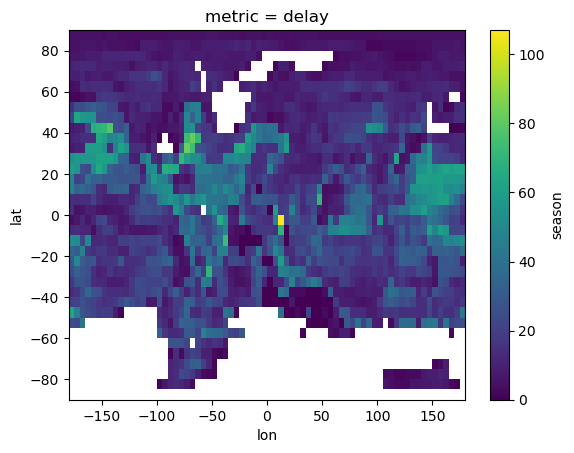

In [108]:
strict_toes.sel(metric="delay")["season"].plot()

In [98]:
delay_toe

<xarray.Dataset> Size: 22kB
Dimensions:  (lat: 36, lon: 72)
Coordinates:
  * lat      (lat) float64 288B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Data variables:
    season   (lat, lon) float64 21kB nan nan nan nan nan ... 5.0 5.0 5.0 5.0 5.0

In [96]:
delay_toe#.drop_vars("quantile")

<xarray.Dataset> Size: 22kB
Dimensions:  (lat: 36, lon: 72)
Coordinates:
  * lat      (lat) float64 288B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Data variables:
    season   (lat, lon) float64 21kB nan nan nan nan nan ... 5.0 5.0 5.0 5.0 5.0

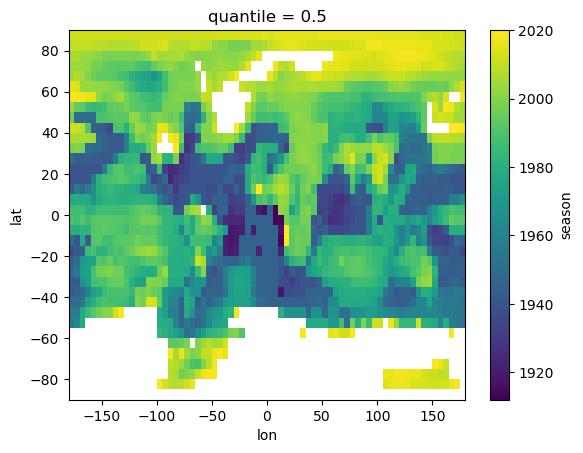

In [87]:
mean_spatial_toe["season"].plot()

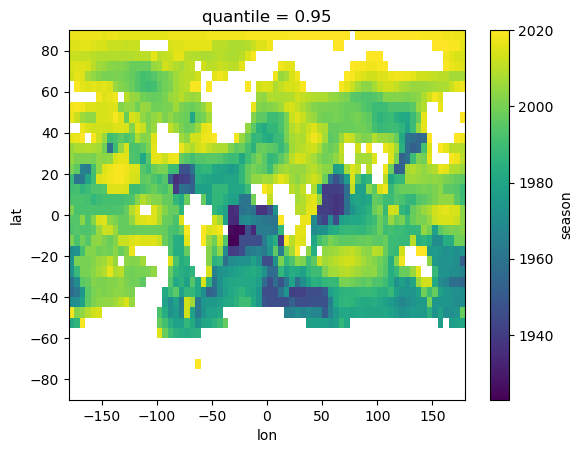

In [83]:
strict_spatial_toe["season"].plot()

## Simple sanity checks

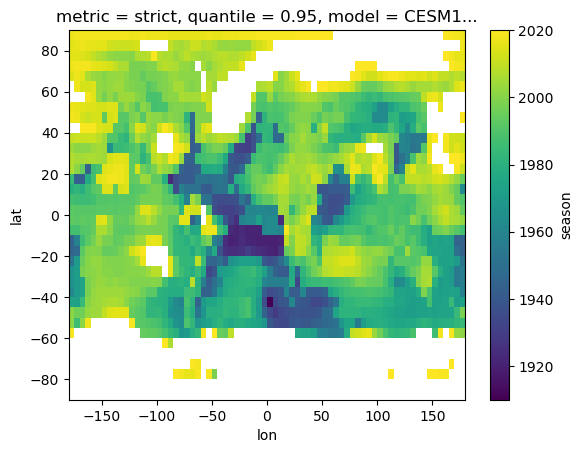

In [32]:
spatial_masked_da["season"].sel(metric="strict", model="CESM1", obs="GISTEMP_5x5").plot()

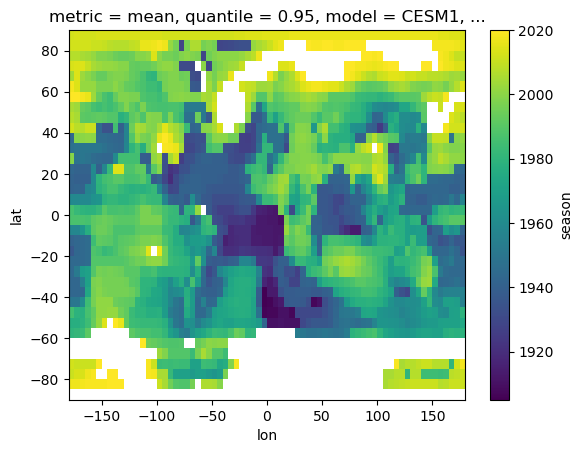

In [ ]:
spatial_masked_da["season"].sel(metric="mean", model="CESM1", obs="GISTEMP_5x5").plot()

In [34]:
regional_masked_da.sel(metric="strict", model="CESM1", obs="HadCRUT")

<xarray.DataArray (RegionIndex: 58)> Size: 464B
array([2010., 1987., 1998., 1994., 2010., 1987., 1940., 1932., 1932.,
       1982., 2006., 1998.,   nan, 1980., 1977., 1962., 2007., 1999.,
       2005., 1986., 1995., 2006., 2018., 2006., 2003., 1962., 1993.,
       1997., 2015., 1997., 1990., 2008., 1999., 1994., 2003., 1953.,
       1994., 1998., 1983., 1958., 1985., 1986., 1950., 1954.,   nan,
         nan, 2017., 1926., 1991., 1980., 1931., 1946., 1954., 1937.,
       1977., 1944., 1979.,   nan])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    metric        <U10 40B 'strict'
    quantile      float64 8B 0.95
    model         <U7 28B 'CESM1'
    obs           <U14 56B 'HadCRUT'

In [35]:
regional_masked_da.sel(metric="mean", model="CESM1", obs="HadCRUT")

<xarray.DataArray (RegionIndex: 58)> Size: 464B
array([2006., 1981., 1995., 1989., 2005., 1933., 1934., 1927., 1931.,
       1926., 1958., 1982., 2003., 1962., 1963., 1953., 2006., 1994.,
       2002., 1935., 1979., 1987., 1988., 1986., 1972., 1940., 1979.,
       1979., 2012., 1992., 1988., 2005., 1994., 1980., 1998., 1945.,
       1930., 1980., 1930., 1931., 1969., 1979., 1942., 1948., 2020.,
         nan, 2015., 1922., 1983., 1979., 1929., 1946., 1954., 1930.,
       1937., 1944., 1972.,   nan])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    metric        <U10 40B 'mean'
    quantile      float64 8B 0.95
    model         <U7 28B 'CESM1'
    obs           <U14 56B 'HadCRUT'

### Other tests

Testing out the DCENT spatial data because the results seem a bit sparse.

In [ ]:
# dcent_unfilled_spatial_trends_all
# dcent_unfilled_spatial_startyears
# cesm1_pic_spatial_trends_all

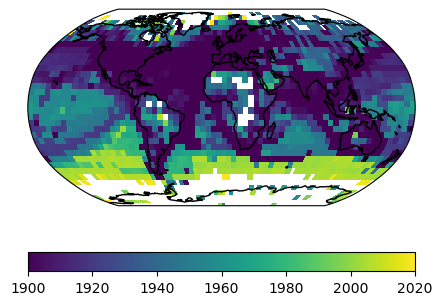

In [33]:
mask = dcent_unfilled_spatial_startyears #.plot()

fig,ax = sp_map(1,1,projection=ccrs.Robinson(),figsize=(5, 4))

im = ax.pcolormesh(
    mask.lon,
    mask.lat,
    mask,
    transform=ccrs.PlateCarree(),
    # cmap=_cmap,
    # norm=_norm, 
)

ax.coastlines()
ax.set_global()

plt.colorbar(im, orientation="horizontal")

In [ ]:
# Test out lat 37.5, lon -157.5.
# This region has a relatively early DCENT start year but is not detected, this seems suspect.

# Test out lat 27.5, lon -37.5.
# This is the north atlantic where DCENT has a 1900 start date but emerges much later than GISTEMP or HadCRUT

# Test out lat -42.5, lon 22.5.
# This is off of the Cape of Good Hope. There really isn't good DCENT start availability here, so I'm not sure how it got a 1900 start year...

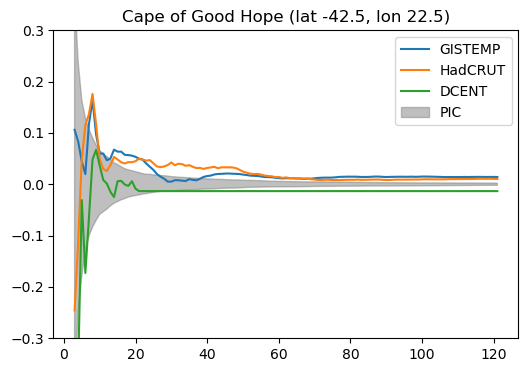

In [34]:
testlat = -42.5
testlon = 22.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.3, 0.3)
ax.set_title(f"Cape of Good Hope (lat {testlat}, lon {testlon})")

plt.legend()

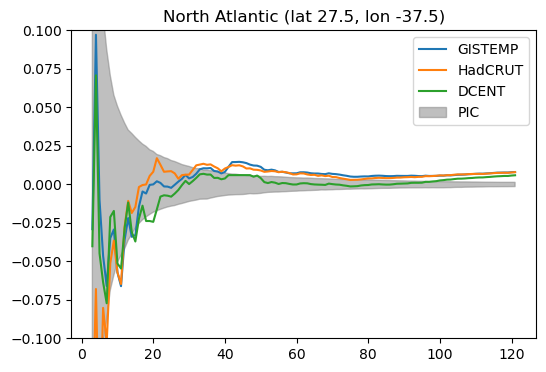

In [35]:
testlat = 27.5
testlon = -37.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.1, 0.1)
ax.set_title("North Atlantic (lat 27.5, lon -37.5)")

plt.legend()

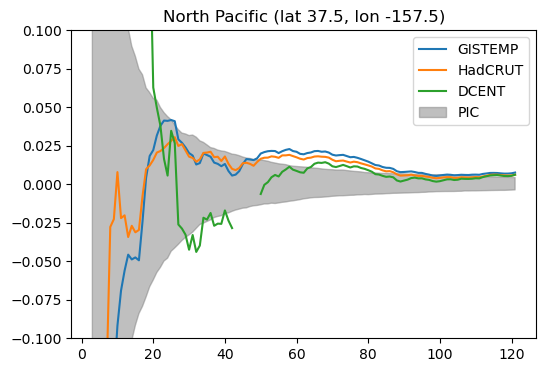

In [28]:
testlat = 37.5
testlon = -157.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    13 + dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.1, 0.1)
ax.set_title("North Pacific (lat 37.5, lon -157.5)")

plt.legend()

Ok, this region seems to make sense with the insight of the cone plot. The DCENT trends are less positive because of the excluded region and the ICV cone is larger.